In [1]:
from helpers import bisection_search, load_obj, save_obj
from networkx import Graph
from graphs import draw_graph, gen_ring_graph
from decoder_class import CascadeDecoder, FastDecoder
import numpy as np
import matplotlib.pyplot as plt
from time import time
from graph_finding import gen_non_isomorphic_graphs
from cascaded import FastResult
import bz2
from random import randint
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from os import getcwd
from multiprocess_graphfinding import graph_perf_on_batch


In [2]:
def txt_to_edge_data(filename):
    output = []
    with open(filename) as f:
        lines = f.readlines()
    for line in lines:
        x = line.split('\t')
        # for a in x:
        #     print(a)
        n_graphs = int(x[1])
        schmidt = x[5]
        edge_list_ix = 10
        for ix in range(len(x)):
            if x[ix] == 'yes' or x[ix] == 'no':
                edge_list_ix = ix + 1

        edge_list = x[edge_list_ix]
        y = edge_list.split(')')
        edges = [(int(e[1+4*j]), int(e[3+4*j])) for e in y for j in range(len(e)//4)]
        # print(edges)
        output.append((n_graphs, edges))
    return output

In [9]:
from os.path import abspath
path_to_data = abspath("../data/uib_data/")


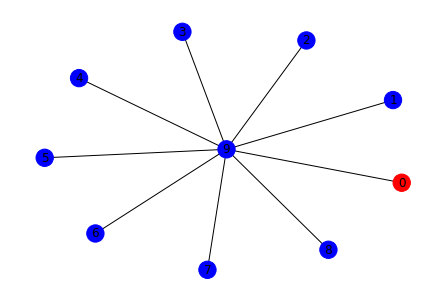

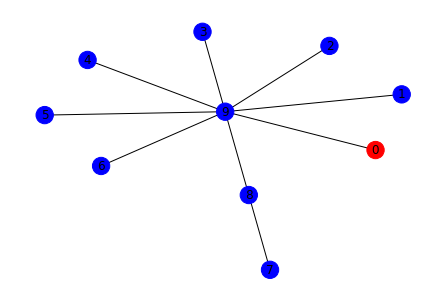

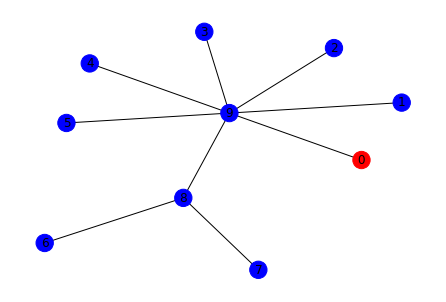

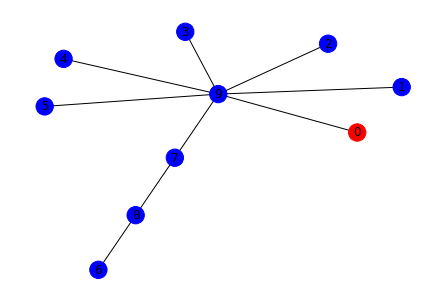

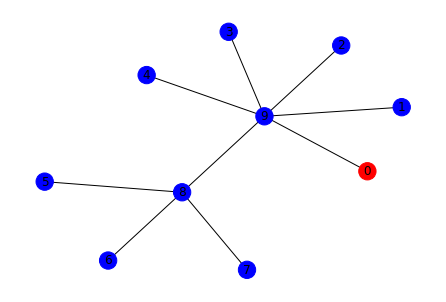

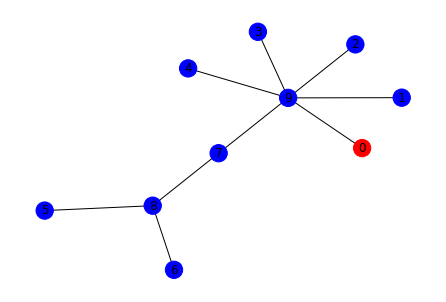

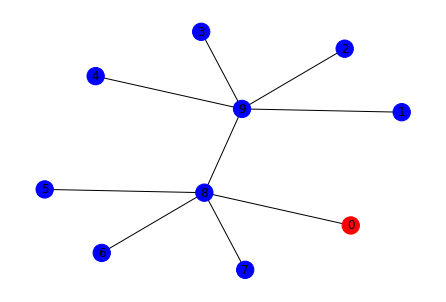

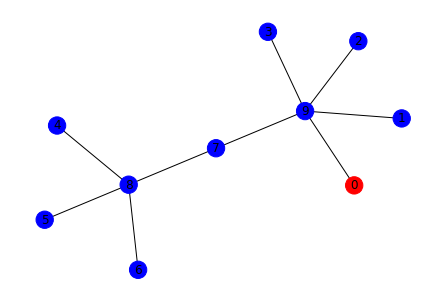

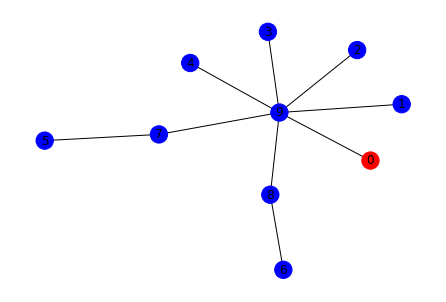

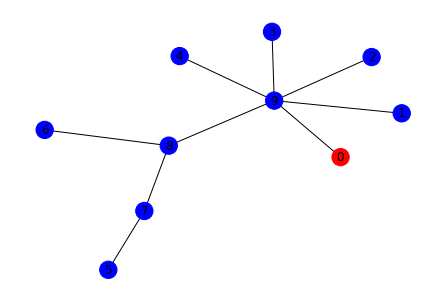

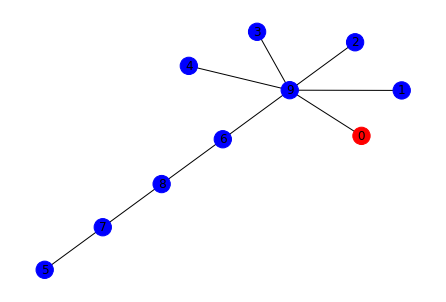

In [7]:
graph_list = txt_to_edge_data(abspath("../data/uib_data/10_qubit_graphs_data_uib.txt"))
i = 0
for g in graph_list:
    i += 1
    graph = Graph()
    graph.add_nodes_from(list(range(max([i for j in g[1] for i in j]))))
    graph.add_edges_from(g[1])
    draw_graph(graph)
    if i > 10:
        break

In [18]:
print(len(graph_list))
all_graphs_data = []
for g in graph_list:
    e = g[1]
    all_graphs_data += [(g[0], x) for x in gen_non_isomorphic_graphs(g[1])]
print(len(all_graphs_data))
print(all_graphs_data[23][0])

3132
25133
16


In [19]:
sorted_by_class_size = sorted(all_graphs_data, key=lambda x: x[0], reverse=True)
save_obj(obj=sorted_by_class_size, path=path_to_data, name="10_qubit_graphs_ordered_num_in_class")


In [50]:
g9 = gen_ring_graph(9)
d9 = CascadeDecoder(g9)
t = time()
d9.build_tree(cascading=True)
print(time() - t)

4.034209966659546


With cascading, the 10 qubit graph takes 5x longer to decode than the 9 qubit graph, at 20 seconds.

Without cascading, it takes 8s. 3142 graphs is then 25000s of computation time. On 10 cores we
have 40 hours of runtime. Additionally, permuting the input qubit adds a factor of 10x, so 400 hours which is
17 days. Using the FastDecoder and no cascading this comes down to 1.5s per 10 qubit graphs.

Checking graph isomorphisms up to the unique input qubit also saves us checking ~10,000 graphs. The expected time is now
1.3 * 22000 ~ 8.5 hours. on 10 cores this is 50 minutes.

In [ ]:
n_threads = cpu_count() - 1
n=10
graph_data = all_graphs_data
n_graphs = len(graph_data)
all_graph_ixs = list(range(n_graphs))
if n_graphs % n_threads:
    per_thread = n_graphs // n_threads + 1
else:
    per_thread = n_graphs / n_threads
input_lists = [list(x) for x in np.array_split(all_graph_ixs, n_threads)]
print(n_graphs, per_thread, n_threads)
graph_lists = [[graph_data[ix] for ix in input_lists[i]] for i in range(n_threads)]  # Take only the first from each equivalence class
#
t0 = time()
with Pool(n_threads) as p:
    out = p.map(graph_perf_on_batch, graph_lists)
t1 = time()
print(t1 - t0)

save_obj(out, f'{n}QubitResultsDicts_PermuteInputFastDecoder', getcwd()+'/LC_equiv_graph_data')



25133 2285 11


In [52]:
data = load_obj('10QubitResultsDicts_PermuteInputFastDecoder', getcwd()+'/LC_equiv_graph_data')
data_flat = [g for d in data for g in d]
print(data_flat[0])
print(len(data_flat))

(EdgeView([(0, 9), (1, 9), (2, 9), (3, 9), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9)]), {(0, 0, 0, 0, 8, 0, 1, 0): 1})
100


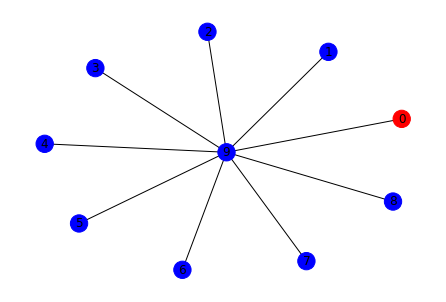

In [53]:
g = Graph()
g.add_edges_from(data_flat[0][0])
draw_graph(g)

In [54]:
star_equivs = gen_non_isomorphic_graphs(graph_list[0])
g = Graph()
g.add_edges_from(star_equivs[0])
draw_graph(g)

NameError: name 'graph_list' is not defined

Inspecting the results of the 10 qubit simulations

In [28]:
from os import getcwd
results = [load_obj(f'10QubitResultsDicts_PermuteInputFastDecoder_batch{i}', path=getcwd() + '/graph_perf_10q') for i in range(23)]

In [29]:
full = []
for r in results:
    flattened = [x for y in r for x in y]
    print(len(flattened))
    full += flattened
print(len(full))

1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
1100
933
25133


In [30]:
best = 0
g_best = None
eta = 0.99
for g in full:
    edges, spcr = g
    r = FastResult(spcr)
    out = r.get_spc_prob(eta)
    if out > best:
        g_best = edges
        best = out
        spcr_best = spcr
print(best)


0.9999858656123908


Inspect the performance of the best sub-threshold 10 qubit graph (9 code qubits). Find it's distance by looking
for the sub-threshold scaling


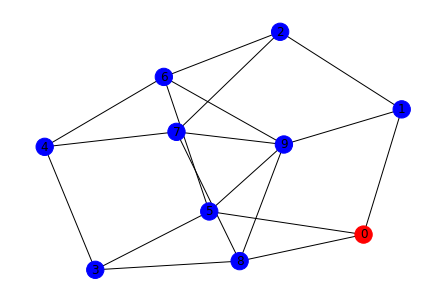

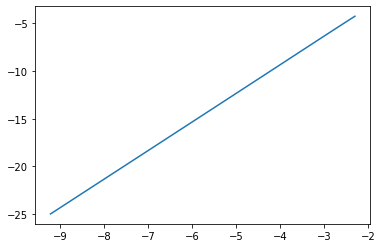

3.001806485080215


In [31]:
g = Graph()
g.add_nodes_from(list(range(10)))
g.add_edges_from(g_best)
draw_graph(g)

low_loss_etas = np.linspace(0.9, 0.9999)
r = FastResult(spcr_best)
eta_log = [r.get_spc_prob(t) for t in low_loss_etas]
log_x = [np.log(1-t) for t in low_loss_etas]
log_y = [np.log(1-tl) for tl in eta_log]
grad = (log_y[-1] - log_y[0])/(log_x[-1] - log_x[0])
plt.plot(log_x, log_y)
plt.show()
print(grad)

etas = np.linspace(0, 1, 1000)
eta_log = [r.get_spc_prob(t) for t in etas]

best_sub_thresh = [g_best, etas, eta_log]
save_obj(best_sub_thresh, 'best_graph_n=10_subthreshold', getcwd())

Now find best threshold

In [32]:
min_threshold = 1
best_thresh_graph = None
best_thresh_spc = None
for graph in full:
    edges, spcr = graph
    r = FastResult(spcr)
    def func(t):
        return r.get_spc_prob(t) - t
    try:
        thresh = bisection_search((0.5, 0.9), func)
    except ValueError:
        # print('NO ROOT')
        thresh = 1
    if thresh <= min_threshold:
        min_threshold = thresh
        best_thresh_graph = graph
        best_thresh_spcr = spcr

In [33]:
r = FastResult(best_thresh_spcr)
etas = np.linspace(0, 1, 1000)
eta_log = [r.get_spc_prob(t) for t in etas]

best_thresh = [best_thresh_graph, etas, eta_log]
save_obj(best_thresh, 'best_graph_n=10_threshold', getcwd())
print(min_threshold)

0.6333984374999999


## Find the distribution of subthreshold and threshold performances

In [44]:
subthresh_perf = []
thresholds = []
for g in full:
    edges, spcr = g
    r = FastResult(spcr)
    subthresh_perf.append(1 - r.get_spc_prob(0.99))
    def func(t):
        return r.get_spc_prob(t) - t
    try:
        thresh = bisection_search((0.5, 0.98), func)
    except ValueError:
        # print('NO ROOT')
        thresh = 1
    if thresh != 1:
        thresholds.append(1- thresh)

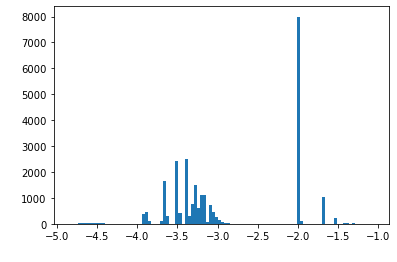

In [50]:
plt.hist(np.log10(subthresh_perf), bins=100)
plt.xlabel('Logical loss at eta=0.99', color='white')
plt.ylabel('Frequency', color='white')
plt.show()

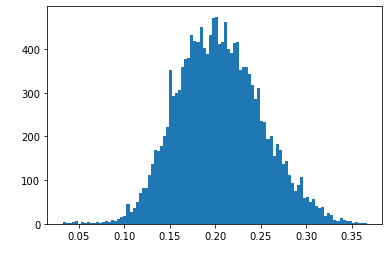

In [51]:
plt.hist(thresholds, bins=100)
plt.xlabel('Threshold', color='white')
plt.ylabel('Frequency', color='white')
plt.show()


# 11 qubit graphs
### #1 Read graphs from zip file

In [64]:
graphs_11q = []
with bz2.open('uib_data/entanglement11.bz2') as f:
    lines = f.readlines()
for line in lines:
    line = line.decode('UTF-8')
    x = line.split('\t')
    # for a in x:
    #     print(a)
    n_graphs = int(x[1])
    schmidt = x[5]
    edge_list_ix = 10
    for ix in range(len(x)):
        if x[ix] == 'yes' or x[ix] == 'no':
            edge_list_ix = ix + 1

    edge_list = x[edge_list_ix]
    e2 = edge_list.replace(')(', ',').removeprefix('(').removesuffix(')').split(',')
    e3 = [_.split('-') for _ in e2]
    e4 = [(int(x[0]), int(x[1])) for x in e3]
    graphs_11q.append(e4)
print(f'There are {len(graphs_11q)} classes of 11 qubit graph state')

There are 40457 classes of 11 qubit graph state


### Get all inequivalent graphs by permuting the input


In [67]:
all_graphs_11q = []
for e in tqdm(graphs_11q):
    all_graphs_11q += gen_non_isomorphic_graphs(e)

100%|██████████| 40457/40457 [05:56<00:00, 113.51it/s]

There are 405741 different graphs for stabilizer pathfinding


In [69]:
save_obj(all_graphs_11q, '11qubitgraphs_input_different', getcwd()+'/uib_data')

In [71]:
print(f'There are {len(all_graphs_11q)} different graphs for stabilizer pathfinding')
print(f'{11 * len(graphs_11q) - len(all_graphs_11q)} have been eliminated due to symmetry')


There are 405741 different graphs for stabilizer pathfinding
39286 have been eliminated due to symmetry


### How long does each simulation take?


In [79]:
t0 = time()

for _ in range(10):
    ix = randint(0, len(all_graphs_11q))
    print(f'{ix=}')
    e = all_graphs_11q[ix]
    g = Graph()
    g.add_nodes_from(list(range(11)))
    g.add_edges_from(e)
    decoder = FastDecoder(g)
    decoder.get_dict()
    eta_logical = decoder.success_prob(0.99)
    print('Transmission = ' + str(eta_logical))
t1 = time()
print(f'Time taken for ten graphs: {t1-t0}s')
print(f'Per graph: {(t1-t0)/10}s')

  0%|          | 0/10 [00:00<?, ?it/s]

ix=368365


 10%|█         | 1/10 [00:06<01:02,  6.90s/it]

Transmission = 0.9995798125465775
ix=389883


 20%|██        | 2/10 [00:17<01:10,  8.82s/it]

Transmission = 0.9999609705948643
ix=365325


 30%|███       | 3/10 [00:24<00:57,  8.18s/it]

Transmission = 0.9996729433825601
ix=289661


 40%|████      | 4/10 [00:31<00:46,  7.72s/it]

Transmission = 0.9998727176750264
ix=73717


 50%|█████     | 5/10 [00:40<00:41,  8.22s/it]

Transmission = 0.9995760656467414
ix=383137


 60%|██████    | 6/10 [00:46<00:30,  7.59s/it]

Transmission = 0.9997802347456828
ix=71271


 70%|███████   | 7/10 [00:54<00:23,  7.73s/it]

Transmission = 0.9899968672780253
ix=168485


 80%|████████  | 8/10 [01:01<00:14,  7.48s/it]

Transmission = 0.9997749648410555
ix=161312


 90%|█████████ | 9/10 [01:08<00:07,  7.07s/it]

Transmission = 0.9995903973588245
ix=77423


100%|██████████| 10/10 [01:16<00:00,  7.67s/it]

Transmission = 0.99959417173746
Time taken for ten graphs: 76.66538095474243s
Per graph: 7.666538095474243s


Simulate graphs using multiprocessing in a script and save the data.
Inspect the distribution of subthreshold performances (eta=0.99) and thresholds

# 12 Qubit graphs

Preliminaries for 12 qubit graphs - get data and search for inequivalent graphs.
Will need to pick graphs from largest classes - so save class sizes as well as graphs

Read all graphs from zip file



In [12]:

graphs_12q = []
with bz2.open('uib_data/entanglement12.bz2') as f:
    lines = f.readlines()
for line in lines:
    line = line.decode('UTF-8')
    x = line.split('\t')
    # for a in x:
    #     print(a)
    n_graphs = int(x[1])
    schmidt = x[5]
    edge_list_ix = 10
    for ix in range(len(x)):
        if x[ix] == 'yes' or x[ix] == 'no':
            edge_list_ix = ix + 1

    edge_list = x[edge_list_ix]
    e2 = edge_list.replace(')(', ',').removeprefix('(').removesuffix(')').split(',')
    e3 = [_.split('-') for _ in e2]
    e4 = [(int(x[0]), int(x[1])) for x in e3]
    graphs_12q.append((n_graphs, e4))
print(f'There are {len(graphs_12q)} classes of 12 qubit graph state')

There are 1274068 classes of 12 qubit graph state


In [6]:
t0 = time()

for _ in tqdm(range(10)):
    ix = randint(0, len(graphs_12q))
    print(f'{ix=}')
    e = graphs_12q[ix]
    g = Graph()
    g.add_nodes_from(list(range(11)))
    g.add_edges_from(e)
    decoder = FastDecoder(g)
    decoder.get_dict()
    eta_logical = decoder.success_prob(0.99)
    print('Transmission = ' + str(eta_logical))
t1 = time()
print(f'Time taken for ten graphs: {t1-t0}s')
print(f'Per graph: {(t1-t0)/10}s')

  0%|          | 0/10 [00:00<?, ?it/s]

ix=632249


 10%|█         | 1/10 [00:28<04:15, 28.34s/it]

Transmission = 0.9997821838036037
ix=990049


 20%|██        | 2/10 [00:58<03:56, 29.58s/it]

Transmission = 0.9998857929418121
ix=295248


 30%|███       | 3/10 [01:24<03:15, 27.93s/it]

Transmission = 0.9898978481901496
ix=215212


 40%|████      | 4/10 [01:55<02:54, 29.10s/it]

Transmission = 0.9899978650596387
ix=158464


 50%|█████     | 5/10 [02:20<02:17, 27.47s/it]

Transmission = 0.989884638746247
ix=1047806


 60%|██████    | 6/10 [02:54<01:59, 29.94s/it]

Transmission = 0.9997809791730861
ix=931791


 70%|███████   | 7/10 [03:23<01:28, 29.51s/it]

Transmission = 0.9998848048583954
ix=282406


 80%|████████  | 8/10 [03:46<00:55, 27.55s/it]

Transmission = 0.9898998081835628
ix=477953


 90%|█████████ | 9/10 [04:13<00:27, 27.37s/it]

Transmission = 0.9897922988439338
ix=536891


100%|██████████| 10/10 [04:48<00:00, 28.81s/it]

Transmission = 0.9997775972841434
Time taken for ten graphs: 288.1749312877655s
Per graph: 28.81749312877655s


at 30s per graph we are looking at 1.5e7 * 30 = 4.5e9 seconds of CPU time.
This is 142 years of CPU time


This is a prohibitively long time, so instead consider the classes that contain the most graphs -
this is often a good proxy for the graphs with the best loss tolerance. Plot a histogram
of the number of graphs in each equivalence class

[243064, 242960, 242960, 242940, 242940, 242940, 242932, 242920, 242912, 242900, 242892, 242892, 242892, 242872, 242864, 242864, 242856, 242844, 242844, 242844]


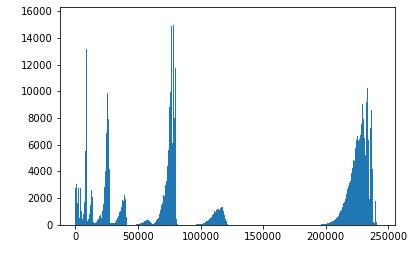

In [25]:
graphs_12q_ordered = sorted(graphs_12q, key=lambda x: x[0], reverse=True)
print([x[0] for x in graphs_12q_ordered[:20]])
plt.hist([x[0] for x in graphs_12q_ordered], bins=1000)
plt.xlabel('Number of graphs in equivalence class', color='white')
plt.ylabel('Frequency', color='white')
plt.show()

In [26]:
save_obj(graphs_12q_ordered, '12qubitgraphs_ordered_num_in_class', getcwd()+'/uib_data')
